# 2. Image Classification & Logistic Regression

- Notes from a [YT Tutorial](https://www.youtube.com/watch?v=GIsg-ZUy0MY)


- Using the MNIST ("Hello World equivalent") sample dataset
- PyTorch method supposedly more OOP like compared to TensorFlow

In [15]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets

0it [11:43, ?it/s]


In [11]:
# Download training dataset

datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]

In [12]:
data = datasets.MNIST(".", download=True)





0it [00:00, ?it/s]Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to ./MNIST/raw/train-images-idx3-ubyte.gz




  0%|          | 0/9912422 [00:01<?, ?it/s]



  0%|          | 8192/9912422 [00:01<04:51, 33955.06it/s]



  0%|          | 40960/9912422 [00:01<01:45, 93364.29it/s]



  1%|          | 90112/9912422 [00:01<00:59, 165800.93it/s]



  2%|▏         | 212992/9912422 [00:02<00:31, 310571.02it/s]



  5%|▍         | 458752/9912422 [00:02<00:16, 574715.03it/s]



  7%|▋         | 720896/9912422 [00:02<00:12, 752679.03it/s]



 15%|█▍        | 1466368/9912422 [00:02<00:05, 1509334.29it/s]



 30%|██▉       | 2940928/9912422 [00:03<00:02, 3007985.36it/s]



 48%|████▊     | 4726784/9912422 [00:03<00:00, 5376760.06it/s]



 60%|█████▉    | 5906432/9912422 [00:03<00:00, 6048148.23it/s]



 90%|████████▉ | 8904704/9912422 [00:03<00:00, 10749294.37it/s]


1654784it [00:28, 171711.70it/s]                             Extracting ./MNIST/raw/train-im

In [13]:
len(data) # Both train and test are in here

60000

In [14]:
test_dataset = datasets.MNIST(root='data/', train=False) # last 10000 are test
len(test_dataset)

10000

In [20]:
print(data[0]) # A tuple with image, and label (target)

(<PIL.Image.Image image mode=L size=28x28 at 0x7FAAECA6B880>, 5)


Label: 5


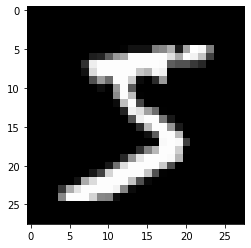

In [21]:
# Quick way to view images

image, label = data[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [22]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the ToTensor transform to convert images into PyTorch tensors.

In [23]:
# MNIST dataset (images and labels) in PyTorch readable format

dataset = datasets.MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [26]:
# Remember that each image in MNIST is a 28*28 pixel grayscale image
# Tensor format adds additional dimension for fit

img_tensor_0, label_0 = dataset[0]
print(img_tensor_0.shape, label_0)

torch.Size([1, 28, 28]) 5


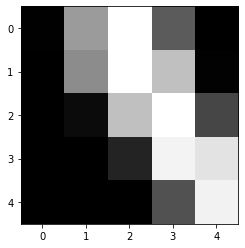

In [27]:
# Plot the image by passing in the 28x28 matrix
# This is specific to the first value
# The output is a section of the image of dataset[0]

plt.imshow(img_tensor_0[0,10:15,10:15], cmap='gray');

## Preprocessing

### Training and Validation (Test) Datasets

In the MNIST dataset, there are 60,000 training images and 10,000 test images. **The test set is standardized** so that different researchers can report their models' results against the same collection of images.


Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [28]:
from torch.utils.data import random_split # like train_test_split
# Data already standardized, otherwise do this too

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.


We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [29]:
# Set batch_size and fit DataLoader

from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True) # Batches of train sets
val_loader = DataLoader(val_ds, batch_size) # Batches of test sets

We set `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

## Model
Now that we have prepared our data loaders, we can define our model.

- A logistic regression model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`).


- As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.


- Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is **flattened** into a vector of size 784 (28*28) before being passed into the model.


- The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [31]:
import torch.nn as nn

input_size = 28*28 # This is your flattened image tensor size
num_classes = 10 # MNIST has 10 outputs/labels (0-9)

# Logistic regression model (note that this uses .Linear too)
model = nn.Linear(input_size, num_classes)

In [32]:
# Weight = coefficients or features
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0022,  0.0206,  0.0263,  ...,  0.0007,  0.0286, -0.0016],
        [-0.0204,  0.0345,  0.0148,  ...,  0.0074, -0.0276,  0.0004],
        [-0.0019,  0.0303,  0.0268,  ...,  0.0072,  0.0336, -0.0064],
        ...,
        [-0.0292, -0.0075, -0.0267,  ...,  0.0212,  0.0175,  0.0042],
        [-0.0354, -0.0031,  0.0104,  ..., -0.0196, -0.0124, -0.0300],
        [-0.0265, -0.0259,  0.0087,  ..., -0.0354, -0.0171, -0.0010]],
       requires_grad=True)

In [33]:
# Bias = intercept or outputs
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0015,  0.0164, -0.0277,  0.0008,  0.0255,  0.0107, -0.0054, -0.0022,
        -0.0161,  0.0132], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [36]:
for images, labels in train_loader:
    print(labels, "\n")
    print(images.shape)
    images_reshaped = images.reshape(128, input_size) # Key here is to reshape
    print(images_reshaped.shape, "\n")
    outputs = model(images_reshaped)
    print(outputs)
    break

tensor([5, 7, 2, 7, 8, 1, 3, 0, 3, 1, 9, 0, 2, 2, 7, 0, 2, 6, 4, 4, 2, 1, 6, 9,
        1, 3, 7, 7, 7, 5, 3, 7, 5, 4, 5, 6, 0, 1, 6, 6, 9, 4, 4, 0, 7, 4, 0, 4,
        7, 4, 1, 9, 8, 7, 0, 7, 5, 5, 6, 2, 4, 5, 2, 4, 4, 2, 2, 9, 8, 8, 0, 6,
        0, 5, 6, 2, 1, 7, 4, 8, 2, 1, 6, 6, 3, 4, 4, 5, 9, 5, 3, 5, 7, 6, 6, 0,
        2, 0, 6, 9, 4, 7, 6, 6, 2, 6, 9, 5, 6, 0, 2, 6, 5, 4, 1, 3, 1, 0, 5, 7,
        1, 2, 1, 5, 2, 4, 1, 0]) 

torch.Size([128, 1, 28, 28])
torch.Size([128, 784]) 

tensor([[ 0.1800, -0.0184,  0.1533,  ...,  0.1284,  0.0009,  0.0221],
        [ 0.0477, -0.0437,  0.0128,  ..., -0.0562, -0.1675, -0.0246],
        [-0.1011, -0.0665, -0.0985,  ...,  0.1421, -0.1161,  0.1995],
        ...,
        [ 0.0248, -0.0145,  0.0570,  ...,  0.0424, -0.3132,  0.2205],
        [-0.0406, -0.0364,  0.1646,  ...,  0.1140, -0.2575,  0.2239],
        [ 0.2925, -0.0489,  0.0175,  ..., -0.0392, -0.1240,  0.3299]],
       grad_fn=<AddmmBackward>)


Notice the differences between `images` & `images_reshaped` --> the latter is flattened for tensor readability.

### Using Classes to extend the functionality of existing classes

- With the `nn.Module` class

In [54]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__() # Inheritance
    
    def fit(self, input_size, num_classes): 
        self.linear = nn.Linear(input_size, num_classes) # copying the fit from nn.Module

    def forward(self, xb, input_size):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb) # fits the flattened tensor instead
        return out

In [55]:
logit = MNISTModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.


`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to `.reshape` can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.


Note that **the model no longer has `.weight` and `.bias` attributes** (as they are now inside the .linear attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [56]:
# Fit your inputs and outputs
logit.fit(784, 10)

In [57]:
logit.linear

Linear(in_features=784, out_features=10, bias=True)

In [58]:
print("Weight: ", logit.linear.weight.shape, "\n")
print("Bias: ", logit.linear.bias.shape, "\n")
list(logit.parameters())

Weight:  torch.Size([10, 784]) 

Bias:  torch.Size([10]) 



[Parameter containing:
 tensor([[ 2.4268e-02,  1.5558e-03,  1.8350e-02,  ...,  2.5305e-02,
           6.3731e-04, -1.0844e-03],
         [-2.1826e-02,  2.1907e-02,  1.6297e-02,  ..., -2.3300e-02,
          -3.4802e-02, -2.6076e-02],
         [ 7.3447e-03,  8.6418e-03, -2.1102e-02,  ...,  1.0218e-02,
          -8.2791e-05,  2.7708e-02],
         ...,
         [-1.4028e-02, -3.4146e-02, -1.1626e-02,  ..., -1.7438e-02,
          -1.9493e-02, -1.2494e-02],
         [ 1.8737e-03,  1.8989e-02,  1.9274e-02,  ...,  3.1755e-03,
           5.1635e-03,  1.6978e-02],
         [-3.4278e-02, -2.1016e-02, -2.8671e-02,  ...,  2.0782e-02,
          -1.0461e-02, -1.9668e-02]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0173, -0.0171, -0.0229,  0.0327, -0.0066,  0.0123, -0.0008, -0.0046,
          0.0026, -0.0250], requires_grad=True)]

In [61]:
# The idea here is that the updated logit model has already flattened the weights

for images, labels in train_loader:
    print(images.shape)
    outputs = logit(images, 784) # input_size (flattened image)
    break

# Outputs have the batch size (128)
print('outputs.shape : ', outputs.shape, "\n") # batch size, and the 0-9 predictions 
print('Sample outputs :\n', outputs[:2].data) # not readable, needs conversion to probabilities

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10]) 

Sample outputs :
 tensor([[-0.0817,  0.0128, -0.2178,  0.2515, -0.0361,  0.1338, -0.1017,  0.0092,
          0.1112,  0.2543],
        [-0.0993, -0.0902,  0.0991,  0.0083,  0.0632,  0.1734, -0.1174,  0.0407,
          0.1393, -0.1159]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.

- To convert the output rows into probabilities, we can use the softmax function, with the formula below:

![image](https://i.imgur.com/EAh9jLN.png)

First we replace each element `yi` in an output row by `e^yi`, making all the elements positive.

![image](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)

Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.


While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [62]:
# The softmax function is in the torch.nn.functional package. 
import torch.nn.functional as F

In [63]:
# Apply softmax for each output row to get probabilities
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row (they obviously must be 1)
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0882, 0.0969, 0.0769, 0.1230, 0.0923, 0.1094, 0.0864, 0.0966, 0.1069,
         0.1234],
        [0.0891, 0.0900, 0.1087, 0.0993, 0.1049, 0.1171, 0.0875, 0.1025, 0.1132,
         0.0877]])
Sum:  1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using `torch.max`, which returns each row's largest element and the corresponding index.

In [64]:
# your predictions (len to batch size)

max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([9, 5, 7, 8, 8, 7, 7, 5, 8, 4, 8, 7, 8, 7, 9, 2, 3, 8, 8, 8, 8, 8, 7, 8,
        0, 4, 9, 8, 9, 6, 3, 2, 8, 4, 1, 7, 0, 7, 8, 8, 3, 4, 8, 7, 0, 4, 4, 7,
        9, 2, 4, 2, 8, 8, 9, 3, 3, 8, 7, 8, 2, 8, 3, 3, 7, 2, 8, 3, 8, 3, 8, 3,
        8, 3, 8, 1, 7, 9, 8, 8, 3, 3, 0, 0, 9, 8, 5, 7, 8, 8, 8, 0, 9, 4, 0, 8,
        2, 2, 8, 8, 9, 2, 8, 9, 7, 8, 7, 7, 8, 8, 2, 8, 4, 7, 3, 7, 0, 8, 8, 2,
        8, 3, 8, 4, 8, 8, 3, 8])
tensor([0.1234, 0.1171, 0.1166, 0.1220, 0.1306, 0.1205, 0.1323, 0.1557, 0.1322,
        0.1224, 0.1173, 0.1703, 0.1507, 0.1468, 0.1325, 0.1185, 0.1384, 0.1101,
        0.1339, 0.1314, 0.1168, 0.1320, 0.1480, 0.1137, 0.1227, 0.1202, 0.1186,
        0.1200, 0.1250, 0.1228, 0.1290, 0.1147, 0.1136, 0.1293, 0.1132, 0.1507,
        0.1217, 0.1343, 0.1236, 0.1220, 0.1406, 0.1167, 0.1195, 0.1335, 0.1215,
        0.1358, 0.1227, 0.1234, 0.1508, 0.1534, 0.1390, 0.1196, 0.1160, 0.1227,
        0.1306, 0.1173, 0.1262, 0.1218, 0.1246, 0.1300, 0.1233, 0.1235, 0.1185,
       

In [65]:
# True labels (also per batch size)
labels

tensor([4, 1, 0, 1, 1, 5, 0, 3, 0, 8, 2, 0, 3, 0, 8, 3, 6, 1, 2, 8, 8, 5, 8, 1,
        7, 3, 4, 1, 9, 9, 0, 1, 1, 2, 7, 0, 7, 8, 1, 1, 4, 4, 6, 5, 6, 3, 7, 8,
        9, 8, 1, 6, 1, 3, 2, 5, 3, 1, 4, 7, 7, 3, 4, 4, 0, 5, 3, 6, 2, 4, 8, 7,
        9, 4, 7, 7, 0, 9, 1, 6, 4, 0, 8, 9, 9, 7, 5, 5, 7, 6, 1, 7, 9, 2, 8, 2,
        7, 6, 1, 9, 5, 8, 1, 9, 0, 7, 5, 5, 2, 9, 3, 3, 1, 0, 7, 0, 2, 6, 4, 5,
        2, 6, 1, 3, 2, 0, 4, 1])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

## Evaluation Metrics and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the accuracy of the predictions.

In [78]:
# Remember that model outputs are probabilities of each of the 0-9 labels
# In this example the first observation has the label of 9 being the most probable (0.2543 chance)

print(torch.max(outputs, dim=1)[0][0])
print(torch.max(outputs, dim=1)[1][0]) # the prediction

tensor(0.2543, grad_fn=<SelectBackward>)
tensor(9)


In [79]:
# To measure accuracy

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The == operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing True for unequal elements and False for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because e^x is an increasing function, i.e., if y1 > y2, then e^y1 > e^y2. The same holds after averaging out the values to get the softmax.

In [80]:
accuracy(outputs, labels)

tensor(0.0938)

#### Comment 

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.


2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

For these reasons, accuracy is often used as an evaluation metric for classification, but not as a loss function. A commonly used loss function for classification problems is the cross-entropy, which has the following formula:

![image](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:
- For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.


- Then, take the logarithm of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![image](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

- Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.


As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [81]:
# Loss function

loss_fn = F.cross_entropy

In [82]:
# Loss for the current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3102, grad_fn=<NllLossBackward>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. The lower the loss, The better the model.

## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

`for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection`
    
Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.


We'll include the problem-independent parts within a function called fit, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the nn.Module class.

In [84]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD): #lr is learning rate

    optimizer = opt_func(model.parameters(), lr) 
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader) # Define this function below
        model.epoch_end(epoch, result)
        history.append(result)

    return history

The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time. It is an active area of research and experimentation in machine learning. Feel free to try different learning rates and see how it affects the training process.

Let's define the evaluate function, used in the validation phase of fit.

In [85]:
# Function specific to a class (like a class method):

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finally, let's redefine the MnistModel class to include additional methods training_step, validation_step, validation_epoch_end, and epoch_end used by fit and evaluate.

In [92]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__() # inherits nn.Module class
        
    def fit(self, input_size, num_classes): 
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb, input_size=input_size):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [93]:
logit = MNISTModel()
# Fit the input and output size
logit.fit(784, 10)

Before we train the model, see how it perfroms on the validation set with the initial set of randomly initialized weights & biases

In [95]:
result0 = evaluate(logit, val_loader)
result0

{'val_loss': 2.324139356613159, 'val_acc': 0.09078323096036911}

The initial accuracy is around 9-10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for five epochs and look at the results.

In [96]:
# 5 epochs, learning rate of 0.1%

history1 = fit(5, 0.001, logit, train_loader, val_loader)

Epoch [0], val_loss: 1.9564, val_acc: 0.5985
Epoch [1], val_loss: 1.6900, val_acc: 0.7032
Epoch [2], val_loss: 1.4903, val_acc: 0.7475
Epoch [3], val_loss: 1.3388, val_acc: 0.7749
Epoch [4], val_loss: 1.2219, val_acc: 0.7905


That's a great result! With just 5 epochs of training, our model has reached an accuracy of nearly 80% on the validation set. Let's see if we can improve that by training for a few more epochs. Try changing the learning rates and number of epochs.

In [97]:
# 10 epochs, keep lr the same
# Bear in mind this keeps the 'history' from above - explains the higher scores

history2 = fit(10, 0.001, logit, train_loader, val_loader)

Epoch [0], val_loss: 1.1298, val_acc: 0.8024
Epoch [1], val_loss: 1.0558, val_acc: 0.8108
Epoch [2], val_loss: 0.9952, val_acc: 0.8173
Epoch [3], val_loss: 0.9447, val_acc: 0.8238
Epoch [4], val_loss: 0.9020, val_acc: 0.8285
Epoch [5], val_loss: 0.8655, val_acc: 0.8330
Epoch [6], val_loss: 0.8339, val_acc: 0.8364
Epoch [7], val_loss: 0.8062, val_acc: 0.8391
Epoch [8], val_loss: 0.7817, val_acc: 0.8413
Epoch [9], val_loss: 0.7600, val_acc: 0.8444


In [98]:
# same epochs, double learning rate
history3 = fit(5, 0.002, logit, train_loader, val_loader)

Epoch [0], val_loss: 0.7229, val_acc: 0.8485
Epoch [1], val_loss: 0.6924, val_acc: 0.8513
Epoch [2], val_loss: 0.6669, val_acc: 0.8555
Epoch [3], val_loss: 0.6452, val_acc: 0.8578
Epoch [4], val_loss: 0.6264, val_acc: 0.8592


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

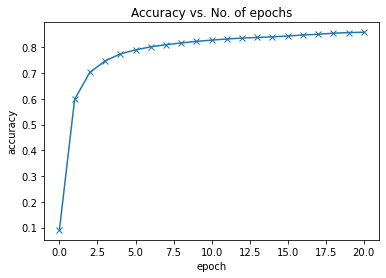

In [99]:
history = [result0] + history1 + history2 + history3
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that the model just isn't powerful enough. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a linear function of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc.

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [100]:
torch.save(logit.state_dict(), 'mnist-logistic.pth')

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model. 

To load the model weights, we can instante a new object of the class MnistModel, and use the .load_state_dict method.

In [101]:
model2 = MNISTModel()
model2.fit(784, 10)

In [102]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0330,  0.0128,  0.0305,  ..., -0.0115,  0.0191, -0.0284],
                      [-0.0271, -0.0348, -0.0181,  ...,  0.0107, -0.0311, -0.0231],
                      [ 0.0263,  0.0129, -0.0317,  ...,  0.0078,  0.0203,  0.0318],
                      ...,
                      [-0.0345, -0.0197,  0.0200,  ..., -0.0343, -0.0017,  0.0334],
                      [-0.0027, -0.0151, -0.0098,  ..., -0.0018,  0.0127, -0.0117],
                      [-0.0354,  0.0346,  0.0343,  ...,  0.0114,  0.0009,  0.0340]])),
             ('linear.bias',
              tensor([-0.0269,  0.0305,  0.0336, -0.0152,  0.0323,  0.0106, -0.0243,  0.0196,
                      -0.0022,  0.0130]))])

In [106]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(logit, test_loader)
result

{'val_loss': 0.5884577035903931, 'val_acc': 0.8675781488418579}

In [107]:
# Default settings
evaluate(model2, test_loader)

{'val_loss': 2.344984769821167, 'val_acc': 0.0947265625}

In [108]:
# How to load the saved, trained model:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0232,  0.0049,  0.0088,  ..., -0.0044, -0.0207,  0.0320],
                      [ 0.0005, -0.0336,  0.0225,  ...,  0.0294,  0.0347,  0.0159],
                      [-0.0180,  0.0310,  0.0156,  ..., -0.0162,  0.0252,  0.0333],
                      ...,
                      [-0.0158, -0.0069, -0.0109,  ...,  0.0327, -0.0042, -0.0012],
                      [-0.0317, -0.0338,  0.0295,  ..., -0.0182,  0.0159,  0.0218],
                      [-0.0168, -0.0170,  0.0179,  ..., -0.0156,  0.0255,  0.0221]])),
             ('linear.bias',
              tensor([-0.0461,  0.1034, -0.0248, -0.0359, -0.0015,  0.0672, -0.0233,  0.0462,
                      -0.1254, -0.0130]))])

In [110]:
# Should be the same as above
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.5884577035903931, 'val_acc': 0.8675781488418579}